In [3]:
import numpy as np
import cv2

def SRAD(img, iterationMaxStep, timeSize, decayFactor):

    # #
    # # INPUT PARAMETERS
    # #
    spatialSize = 1
    t = 0
    thresholdDiffusion = 0.0001
    thresholdConvergence = 10**(-13)
    ROW, COL = img.shape ## input image size
    epsilon = 10**(-13)
    iterationNumber = 0
    diviationConvergence = 1
    originalClass = type(img)
    
    img = img.astype('float32')
    img_i_j_ = img
    temp = img_i_j_[::spatialSize, :]
    img_i_j = temp[:,::spatialSize]
    img_ia1_j = np.row_stack((img_i_j, img_i_j[-1,:]))
    img_ia1_j = img_ia1_j[1:,:]
    img_is1_j = np.row_stack((img_i_j[0,:], img_i_j))
    img_is1_j = img_is1_j[:-1,:]
    img_i_ja1 = np.column_stack((img_i_j, img_i_j[:,-1]))
    img_i_ja1 = img_i_ja1[:,1:]
    img_i_js1 = np.column_stack((img_i_j[:,0], img_i_j))
    img_i_js1 = img_i_js1[:,:-1]

    ## #
    # # STEP1: compute derivative approximation and Laplacian approximation
    # #
    deltaR1Img = (img_ia1_j - img_i_j)/spatialSize
    deltaR2Img = (img_i_ja1 - img_i_j)/spatialSize
    
    deltaL1Img = (img_i_j - img_is1_j)/spatialSize
    deltaL2Img = (img_i_j - img_i_js1)/spatialSize
    
    delta2Img = (img_ia1_j + img_is1_j + img_i_ja1 + img_i_js1 - 4*img_i_j)/(spatialSize*spatialSize)

    ## #
    # # STEP2: caculate the diffusion coefficient
    # #
    ## normalizing the gradient of each image point
    gradientTotal = np.sqrt( np.multiply(deltaR1Img,deltaR1Img) + np.multiply(deltaR2Img,deltaR2Img) + np.multiply(deltaL1Img,deltaL1Img) + np.multiply(deltaL2Img,deltaL2Img) )
    deltaImgNormal = np.divide(gradientTotal,(img_i_j + epsilon))
    
    ## normalizing the Laplacian of each imge point
    delta2ImgNormal = np.divide(delta2Img,(img_i_j+epsilon))
    
    ## # compute the initial Q
    temp1 = np.multiply(deltaImgNormal,deltaImgNormal)*0.5 - np.multiply(delta2ImgNormal,delta2ImgNormal)/16
    temp2 = 1+0.25*delta2ImgNormal
    temp3 = np.multiply(temp2,temp2)
        
    q = np.sqrt(np.divide(temp1,temp3))
    Q = q
    
    #IDK# Q_0 = logical(Q)
    Q_0 = Q != 0
    #IDK# Q_0 = single(Q_0)
    Q_0 = Q_0.astype('float32')

    Img_i_j = img_i_j

    # Canny edge detection
    #edges = cv2.Canny(img_i_j.astype(np.uint8), canny_low_threshold, canny_high_threshold)
    #edges = edges.astype(np.float32)

    while iterationNumber <= iterationMaxStep:
        img_i_j = Img_i_j
        img_ia1_j = np.row_stack((img_i_j, img_i_j[-1,:]))
        img_ia1_j = img_ia1_j[1:,:]
        img_is1_j = np.row_stack((img_i_j[0,:], img_i_j))
        img_is1_j = img_is1_j[:-1,:]
        img_i_ja1 = np.column_stack((img_i_j, img_i_j[:,-1]))
        img_i_ja1 = img_i_ja1[:,1:]
        img_i_js1 = np.column_stack((img_i_j[:,0], img_i_j))
        img_i_js1 = img_i_js1[:,:-1]

        # #
        # # STEP1: compute derivative approximation and Laplacian approximation
        # #
        deltaR1Img = (img_ia1_j - img_i_j)/spatialSize
        deltaR2Img = (img_i_ja1 - img_i_j)/spatialSize
        deltaL1Img = (img_i_j - img_is1_j)/spatialSize
        deltaL2Img = (img_i_j - img_i_js1)/spatialSize
        delta2Img = (img_ia1_j + img_is1_j + img_i_ja1 + img_i_js1 - 4*img_i_j)/(spatialSize*spatialSize)

        # #
        # # STEP2: caculate the diffusion coefficient
        # #
        gradientTotal = np.sqrt(np.multiply(deltaR1Img,deltaR1Img) + np.multiply(deltaR2Img,deltaR2Img) + np.multiply(deltaL1Img,deltaL1Img) + np.multiply(deltaL2Img,deltaL2Img))
        deltaImgNormal = np.divide(gradientTotal,(img_i_j+ epsilon))
        delta2ImgNormal = np.divide(delta2Img,(img_i_j+epsilon))
        temp1 = np.multiply(deltaImgNormal,deltaImgNormal)*0.5 - np.multiply(delta2ImgNormal,delta2ImgNormal)/16
        temp2 = 1 + 0.25*delta2ImgNormal
        temp3 = np.multiply(temp2,temp2)
        q = np.sqrt(np.divide(temp1,temp3))
        q_0 = Q_0 * np.exp(-decayFactor*t)
        temp4 = np.multiply(q_0,q_0)
        temp5 = np.multiply(q,q)
        temp6 = np.divide( (temp5-temp4), ( np.multiply(temp4, (1+temp4) ) + epsilon) )
        coefficientDiff = np.exp(-temp6/6)
        
        # Use edges to adjust diffusion coefficients
        #coefficientDiff *= (1 - edges)  # Reduce diffusion near edges

        # #
        # # STEP3: caculate the divergence of diffusion function
        # #
        coe_i_j = coefficientDiff
        
        coe_ia1_j = np.row_stack((coefficientDiff, coefficientDiff[-1,:]))
        coe_ia1_j = coe_ia1_j[1:,:]
        
        coe_i_ja1 = np.column_stack((coefficientDiff, coefficientDiff[:,-1]))
        coe_i_ja1 = coe_i_ja1[:,1:]
        temp6 = np.multiply(coe_ia1_j,deltaR1Img) - np.multiply(coe_i_j,deltaL1Img) + np.multiply(coe_i_ja1,deltaR2Img) - np.multiply(coe_i_j,deltaL2Img)
        div = temp6/spatialSize

        # # STEP4: define the iteration rule
        Img_i_j = img_i_j + (timeSize/4)*div
        
        t = t + timeSize
        
        iterationNumber = iterationNumber + 1
               
    
    #return Img_i_j.astype("uint8")
    
    # #
    # #  STEP5: restore the image
    # #
    mask = np.ones((ROW, COL))
    spatialSize = 1
    mask[::spatialSize, ::spatialSize] = 0


    despeckledImg = img
    despeckledImg = np.multiply(img, mask)

    ROW_, COL_ = Img_i_j.shape

    for i in range(ROW_):
        for j in range(COL_): 
            despeckledImg[i*spatialSize][j*spatialSize] = Img_i_j[i][j]
        
    ## # restore the original data type
    # despeckledImg = cast(despeckledImg, originalClass);
    return despeckledImg.astype("uint8")


C:\Users\User\AppData\Local\Temp\ipykernel_5384\2220714255.py:58: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\User\AppData\Local\Temp\ipykernel_5384\2220714255.py:101: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))


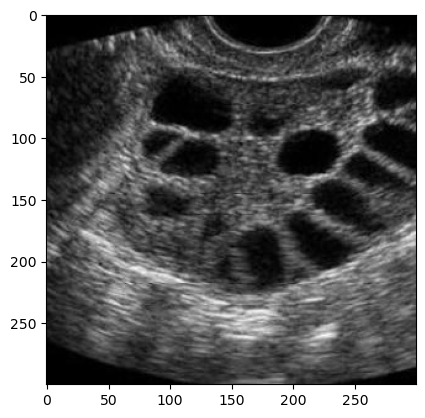

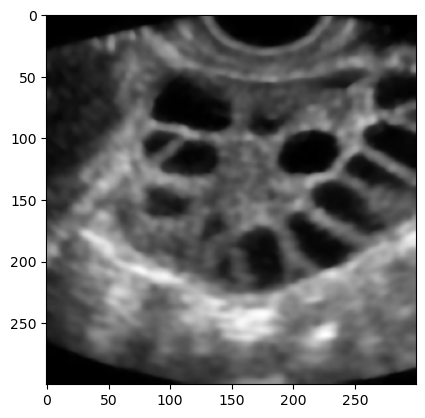

In [40]:
import matplotlib.pyplot as plt
import tensorflow as tf

f = r'D:\PCOS_Challenge\Old folder\Test data\images\image10012.jpg'
img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
#np.savetxt("initial.csv", img, delimiter=",")
#cv2.imshow('Actual Image', img)
plt.figure()
plt.imshow(img, cmap='gray')
#plt.imsave(r'D:\PCOS_Challenge\MIA_Project\images\original.jpg', img, cmap='gray')

iterationMaxStep, timeSize, decayFactor = 200,.05,0.3
img = SRAD(img, iterationMaxStep, timeSize, decayFactor)

#cv2.imwrite('D:\PCOS_Challenge\denoised.png',img)
plt.figure()
plt.imshow(img, cmap='gray')
#plt.imsave(r'D:\PCOS_Challenge\MIA_Project\images\original_filtered.jpg', img, cmap='gray')

In [41]:
import os
from tqdm import tqdm

# Define the path to your dataset
original_data_path = r"D:\PCOS_Challenge\New folder\train\aug_healthy"

# Define the path to save the augmented dataset
filtered_data_path = r"D:\PCOS_Challenge\New folder\train\filtered_healthy"
os.makedirs(filtered_data_path, exist_ok=True)

#fig, ax = plt.subplots(1, 2 + 1, figsize=(12, 2))

## Initialization
iterationMaxStep, timeSize, decayFactor = 200,.05,0.3
i=1
# Iterate through each image in the class
for img_name in tqdm(os.listdir(original_data_path)):
    img_path = os.path.join(original_data_path, img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = SRAD(img, iterationMaxStep, timeSize, decayFactor)

    filtered_img_name = f"{img_name}_filter_{i}.png"
    i=i+1
    filtered_img_path = os.path.join(filtered_data_path, filtered_img_name)
    
    plt.imsave(filtered_img_path, img, cmap='gray')


  0%|▏                                                                                | 5/1626 [00:02<10:39,  2.53it/s]C:\Users\User\AppData\Local\Temp\ipykernel_5384\2220714255.py:58: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\User\AppData\Local\Temp\ipykernel_5384\2220714255.py:101: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))
  1%|▍                                                                               | 10/1626 [00:03<10:35,  2.54it/s]C:\Users\User\AppData\Local\Temp\ipykernel_5384\2220714255.py:101: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\User\AppData\Local\Temp\ipykernel_5384\2220714255.py:153: RuntimeWarning: invalid value encountered in cast
  return despeckledImg.astype("uint8")
100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [08:18<00:00,  3.26it/s]
